### ENSO composites for 20CR extremes

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
from importlib import reload
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Open HadISST for caculating Nino3.4 index 
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [3]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [4]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1901-6', '2015-5'))/sst_std

In [5]:
# Calculate ENSO years with HadISST
el_nino_years, la_nina_years = func.find_event_years(nino34_index, 0.4, 6)
#offset years for djf and mam
el_nino_years_offset = el_nino_years +1
la_nina_years_offset = la_nina_years +1

### Mean temperature composites 

In [6]:
# Open detrended mean temp anomalies from 20CR 
tmp = xr.open_dataarray('/g/data/w40/rl5183/progress_files/anom.nc', chunks={'member':1}).sel(time=slice('1901-6', '2015-5'))
# Add season year axis 
func.seasonyear(tmp)
# Calculate seasonal means 
seasonal_tmp = tmp.groupby('seasonyear').apply(func.seasonal_mean)

In [7]:
#select out each season
tmp_jja = seasonal_tmp.sel(season='JJA')
tmp_son = seasonal_tmp.sel(season='SON')
tmp_djf = seasonal_tmp.sel(season='DJF')
tmp_mam = seasonal_tmp.sel(season='MAM')
#select out el nino years and minus mean (offset for DJF and MAM)
tmp_jja_el_nino = tmp_jja.sel(seasonyear=el_nino_years) - tmp_jja.mean(dim='seasonyear')
tmp_son_el_nino = tmp_son.sel(seasonyear=el_nino_years) - tmp_son.mean(dim='seasonyear')
tmp_djf_el_nino = tmp_djf.sel(seasonyear=el_nino_years_offset) - tmp_djf.mean(dim='seasonyear')
tmp_mam_el_nino = tmp_mam.sel(seasonyear=el_nino_years_offset) - tmp_mam.mean(dim='seasonyear')
#select out la nina years
tmp_jja_la_nina = tmp_jja.sel(seasonyear=la_nina_years) - tmp_jja.mean(dim='seasonyear')
tmp_son_la_nina = tmp_son.sel(seasonyear=la_nina_years) - tmp_son.mean(dim='seasonyear')
tmp_djf_la_nina = tmp_djf.sel(seasonyear=la_nina_years_offset) - tmp_djf.mean(dim='seasonyear')
tmp_mam_la_nina = tmp_mam.sel(seasonyear=la_nina_years_offset) - tmp_mam.mean(dim='seasonyear')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarnin

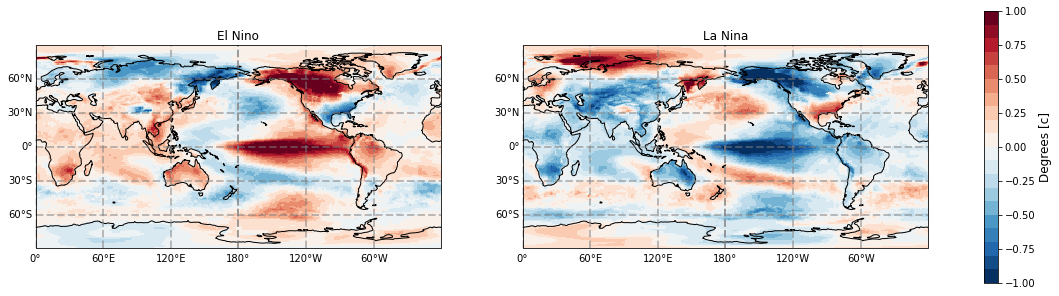

In [8]:
# Plot el nino and la nina composites for mean temp 
fig = plt.figure(figsize=(20,10))
axs = []

vmin = -1
vmax = 1

ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
C = tmp_djf_el_nino.mean(dim=['member', 'time']).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('El Nino')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
C = tmp_djf_la_nina.mean(dim=['member', 'time']).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('La Nina')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


# Colorbar
cbar = plt.colorbar(C, ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('Degrees [c]', fontsize=12)

plt.savefig('ENSO_composites_mean_temp_20CR_djf.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### Mean precipitation composites 

In [9]:
# Open precip anomalies from 20CR 
prate = xr.open_dataarray('/g/data/w40/rl5183/progress_files/anom_prate.nc', chunks={'member':1}).sel(time=slice('1901-6', '2015-5'))
# Add season year axis 
func.seasonyear(prate)
# Calculate seasonal means 
seasonal_prate = prate.groupby('seasonyear').apply(func.seasonal_mean)

In [10]:
#select out each season
prate_jja = seasonal_prate.sel(season='JJA')
prate_son = seasonal_prate.sel(season='SON')
prate_djf = seasonal_prate.sel(season='DJF')
prate_mam = seasonal_prate.sel(season='MAM')
#select out el nino years and minus mean (offset for DJF and MAM)
prate_jja_el_nino = prate_jja.sel(seasonyear=el_nino_years) - prate_jja.mean(dim='seasonyear')
prate_son_el_nino = prate_son.sel(seasonyear=el_nino_years) - prate_son.mean(dim='seasonyear')
prate_djf_el_nino = prate_djf.sel(seasonyear=el_nino_years_offset) - prate_djf.mean(dim='seasonyear')
prate_mam_el_nino = prate_mam.sel(seasonyear=el_nino_years_offset) - prate_mam.mean(dim='seasonyear')
#select out la nina years
prate_jja_la_nina = prate_jja.sel(seasonyear=la_nina_years) - prate_jja.mean(dim='seasonyear')
prate_son_la_nina = prate_son.sel(seasonyear=la_nina_years) - prate_son.mean(dim='seasonyear')
prate_djf_la_nina = prate_djf.sel(seasonyear=la_nina_years_offset) - prate_djf.mean(dim='seasonyear')
prate_mam_la_nina = prate_mam.sel(seasonyear=la_nina_years_offset) - prate_mam.mean(dim='seasonyear')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarnin

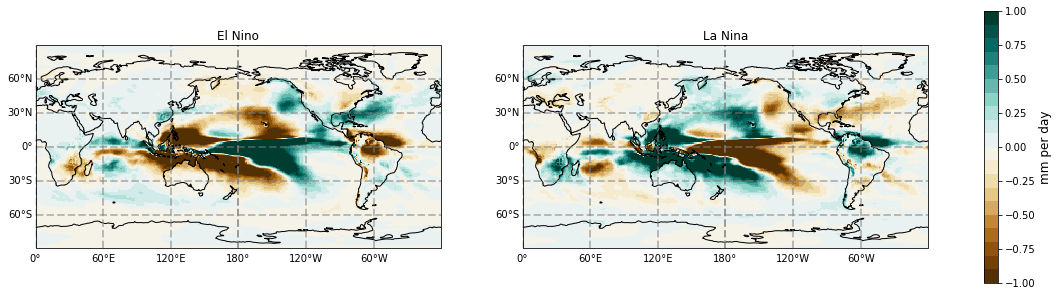

In [11]:
fig = plt.figure(figsize=(20,10))
axs = []

vmin = -1
vmax = 1

ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
C = prate_djf_el_nino.mean(dim=['member', 'time']).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('El Nino')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
C = prate_djf_la_nina.mean(dim=['member', 'time']).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('La Nina')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


# Colorbar
cbar = plt.colorbar(C, ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('mm per day', fontsize=12)

plt.savefig('ENSO_composites_mean_precip_20CR_djf.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### TXx composites

In [12]:
TXx = xr.open_dataarray('/g/data/w40/rl5183/progress_files/TXx_detrended.nc', chunks={'member':1}).sel(time=slice('1901-6', '2015-5'))
# Add season year axis 
func.seasonyear(TXx)
# Calculate seasonal means 
seasonal_TXx = TXx.groupby('seasonyear').apply(func.seasonal_max)

In [13]:
#select out each season
TXx_jja = seasonal_TXx.sel(season='JJA')
TXx_son = seasonal_TXx.sel(season='SON')
TXx_djf = seasonal_TXx.sel(season='DJF')
TXx_mam = seasonal_TXx.sel(season='MAM')
#select out el nino years and minus mean (offset for DJF and MAM)
TXx_jja_el_nino = TXx_jja.sel(seasonyear=el_nino_years) - TXx_jja.mean(dim='seasonyear')
TXx_son_el_nino = TXx_son.sel(seasonyear=el_nino_years) - TXx_son.mean(dim='seasonyear')
TXx_djf_el_nino = TXx_djf.sel(seasonyear=el_nino_years_offset) - TXx_djf.mean(dim='seasonyear')
TXx_mam_el_nino = TXx_mam.sel(seasonyear=el_nino_years_offset) - TXx_mam.mean(dim='seasonyear')
#select out la nina years
TXx_jja_la_nina = TXx_jja.sel(seasonyear=la_nina_years) - TXx_jja.mean(dim='seasonyear')
TXx_son_la_nina = TXx_son.sel(seasonyear=la_nina_years) - TXx_son.mean(dim='seasonyear')
TXx_djf_la_nina = TXx_djf.sel(seasonyear=la_nina_years_offset) - TXx_djf.mean(dim='seasonyear')
TXx_mam_la_nina = TXx_mam.sel(seasonyear=la_nina_years_offset) - TXx_mam.mean(dim='seasonyear')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarnin

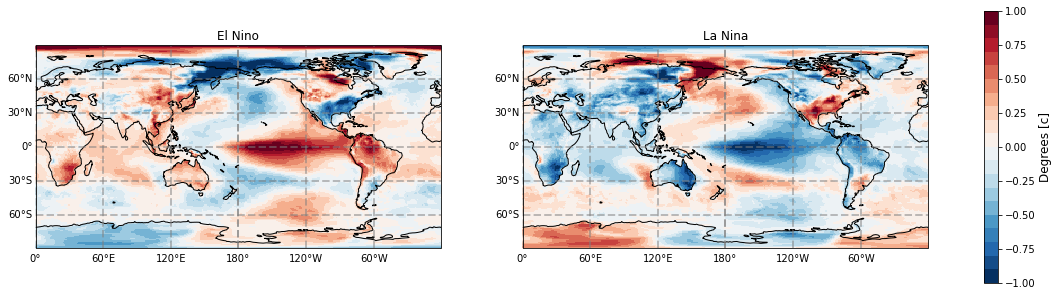

In [14]:
fig = plt.figure(figsize=(20,10))
axs = []

vmin = -1
vmax = 1

ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
C = TXx_djf_el_nino.mean(dim=['member', 'time']).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('El Nino')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
C = TXx_djf_la_nina.mean(dim=['member', 'time']).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('La Nina')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


# Colorbar
cbar = plt.colorbar(C, ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('Degrees [c]', fontsize=12)

plt.savefig('ENSO_composites_TXx_20CR_djf.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### TNn composites 

In [15]:
TNn = xr.open_dataarray('/g/data/w40/rl5183/progress_files/TNn_detrended.nc', chunks={'member':1}).sel(time=slice('1901-6', '2015-5'))
# Add season year axis 
func.seasonyear(TNn)
# Calculate seasonal means 
seasonal_TNn = TNn.groupby('seasonyear').apply(func.seasonal_min)

In [16]:
#select out each season
TNn_jja = seasonal_TNn.sel(season='JJA')
TNn_son = seasonal_TNn.sel(season='SON')
TNn_djf = seasonal_TNn.sel(season='DJF')
TNn_mam = seasonal_TNn.sel(season='MAM')
#select out el nino years and minus mean (offset for DJF and MAM)
TNn_jja_el_nino = TNn_jja.sel(seasonyear=el_nino_years) - TNn_jja.mean(dim='seasonyear')
TNn_son_el_nino = TNn_son.sel(seasonyear=el_nino_years) - TNn_son.mean(dim='seasonyear')
TNn_djf_el_nino = TNn_djf.sel(seasonyear=el_nino_years_offset) - TNn_djf.mean(dim='seasonyear')
TNn_mam_el_nino = TNn_mam.sel(seasonyear=el_nino_years_offset) - TNn_mam.mean(dim='seasonyear')
#select out la nina years
TNn_jja_la_nina = TNn_jja.sel(seasonyear=la_nina_years) - TNn_jja.mean(dim='seasonyear')
TNn_son_la_nina = TNn_son.sel(seasonyear=la_nina_years) - TNn_son.mean(dim='seasonyear')
TNn_djf_la_nina = TNn_djf.sel(seasonyear=la_nina_years_offset) - TNn_djf.mean(dim='seasonyear')
TNn_mam_la_nina = TNn_mam.sel(seasonyear=la_nina_years_offset) - TNn_mam.mean(dim='seasonyear')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarnin

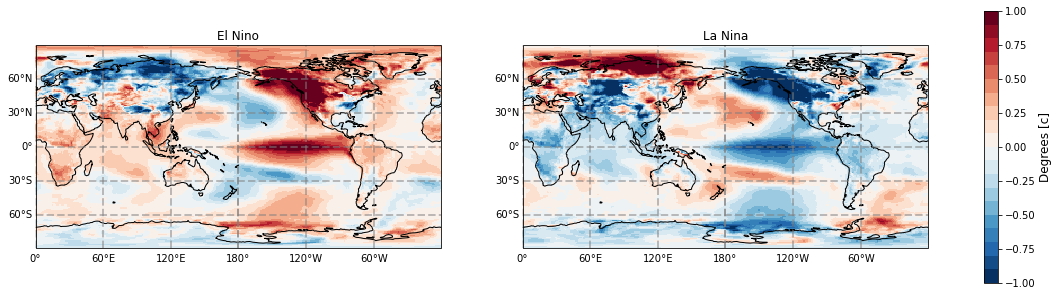

In [17]:
fig = plt.figure(figsize=(20,10))
axs = []

vmin = -1
vmax = 1

ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
C = TNn_djf_el_nino.mean(dim=['member', 'time']).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('El Nino')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
C = TNn_djf_la_nina.mean(dim=['member', 'time']).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('La Nina')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


# Colorbar
cbar = plt.colorbar(C, ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('Degrees [c]', fontsize=12)

plt.savefig('ENSO_composites_TNn_20CR_djf.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### Rx1day composites 

In [18]:
Rx1 = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/monthly_Rx1day_all_members_1x1.nc', chunks={'member':1}).sel(time=slice('1901-6', '2015-5'))*86400

In [19]:
# Add season year axis 
func.seasonyear(Rx1)
# Calculate seasonal means 
seasonal_Rx1 = Rx1.groupby('seasonyear').apply(func.seasonal_max)

In [20]:
#select out each season
Rx1_jja = seasonal_Rx1.sel(season='JJA')
Rx1_son = seasonal_Rx1.sel(season='SON')
Rx1_djf = seasonal_Rx1.sel(season='DJF')
Rx1_mam = seasonal_Rx1.sel(season='MAM')
#select out el nino years and minus mean (offset for DJF and MAM)
Rx1_jja_el_nino = Rx1_jja.sel(seasonyear=el_nino_years) - Rx1_jja.mean(dim='seasonyear')
Rx1_son_el_nino = Rx1_son.sel(seasonyear=el_nino_years) - Rx1_son.mean(dim='seasonyear')
Rx1_djf_el_nino = Rx1_djf.sel(seasonyear=el_nino_years_offset) - Rx1_djf.mean(dim='seasonyear')
Rx1_mam_el_nino = Rx1_mam.sel(seasonyear=el_nino_years_offset) - Rx1_mam.mean(dim='seasonyear')
#select out la nina years
Rx1_jja_la_nina = Rx1_jja.sel(seasonyear=la_nina_years) - Rx1_jja.mean(dim='seasonyear')
Rx1_son_la_nina = Rx1_son.sel(seasonyear=la_nina_years) - Rx1_son.mean(dim='seasonyear')
Rx1_djf_la_nina = Rx1_djf.sel(seasonyear=la_nina_years_offset) - Rx1_djf.mean(dim='seasonyear')
Rx1_mam_la_nina = Rx1_mam.sel(seasonyear=la_nina_years_offset) - Rx1_mam.mean(dim='seasonyear')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarnin

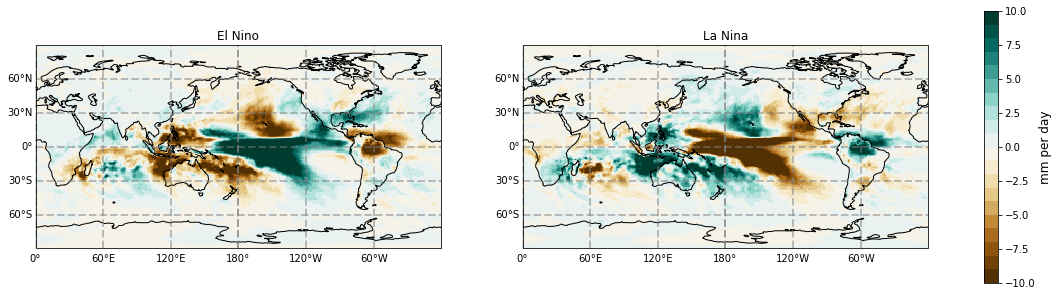

In [21]:
fig = plt.figure(figsize=(20,10))
axs = []

vmin = -10
vmax = 10

ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
C = Rx1_djf_el_nino.mean(dim=['member', 'time']).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('El Nino')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
C = Rx1_djf_la_nina.mean(dim=['member', 'time']).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('La Nina')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


# Colorbar
cbar = plt.colorbar(C, ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('mm per day', fontsize=12)

plt.savefig('ENSO_composites_Rx1day_20CR_djf.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)